### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
from IPython.display import display,HTML

# Int cufflinks
#making all charts public and setting a global theme
cf.set_config_file(theme='solar',offline=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set matplotlib in Darkmode
plt.style.use('dark_background')

### Exploring the Dataset

In [2]:
def load_dataset(path:str) -> pd:
    return pd.read_csv(path)

In [3]:
# Loading data using pandas
path = './diabetes.csv'
dataset = load_dataset(path)

In [4]:
# Check the number of rows and columns in the dataset 
# dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# Shows if there are any entries that are NA or NAN
dataset.isna().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [6]:
columns = list(dataset.columns)

In [7]:
#Plotting data
def plot_data(dataset):
    """Plot out all the data from the dataset in different histograms"""
    dataset.hist(bins=50, figsize = (20,15))
    plt.show()
    return

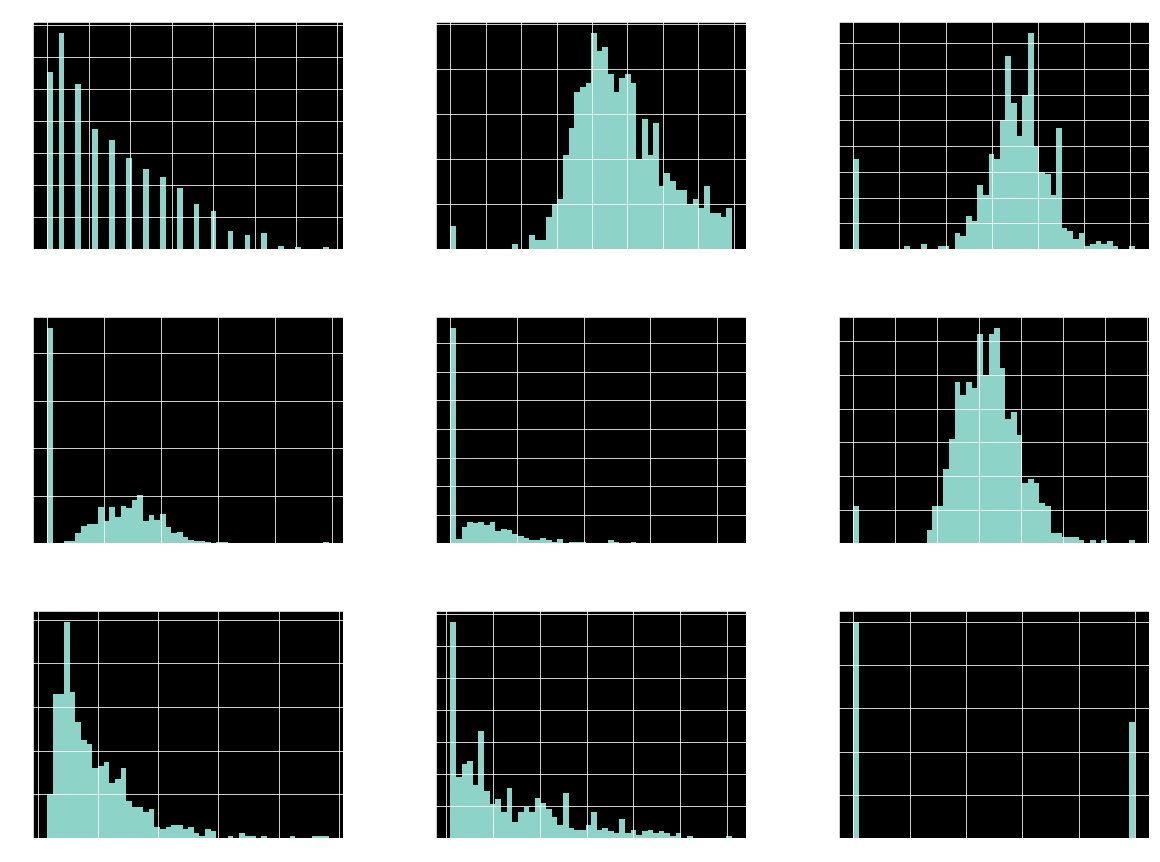

In [8]:
plot_data(dataset)


### Running and Parameters

##### Run Regresion Algorithm

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

'''Run KNN algorithm in pandas dataframe'''

# Create features and labels
features = dataset.drop(['Outcome'], axis=1)
labels = dataset['Outcome']

# Create training (75%) and test (25%) sets 
features_train, features_test , labels_train , labels_test = train_test_split(features, labels, test_size =0.25)

#Set classifier (k=5)
classifier = LogisticRegression()

# Fit data for training into classifier
classifier.fit(features_train, labels_train)

# Predicting with classifier
pred = classifier.predict(features_test)

##### Check Parameters

In [10]:
# Check AOC ARC curve
from sklearn.metrics import roc_auc_score, roc_curve

def aoc_arc_curve(pred, labels_test):
    """Plots the AOC ARC curve and score"""
    auc = roc_auc_score(labels_test, pred)
    print('AUROC score: {:.2f}'.format(auc))

    false_positive_rate, true_positive_rate, thresolds = roc_curve(labels_test, pred)

    plt.figure(figsize=(5, 4), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve", color='white')
    plt.plot(false_positive_rate, true_positive_rate, 'y')
    
    plt.plot([0,1],[0,1], linestyle='dotted')

    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightyellow', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = {:.2f}'.format(auc), ha='right', fontsize=12, weight='bold')
    plt.xlabel("False Positive Rate", color='white')
    plt.ylabel("True Positive Rate", color='white')
    plt.show()
    
    return auc

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def parameter_check(pred, labels_test):
    """Determines accuracy, precision, recall, f1 and aoc arc curve"""
    # Check accuracy
    accuracy = accuracy_score(labels_test , pred)

    # Check precision
    precision = precision_score(labels_test , pred)

    # Check recall
    recall = recall_score(labels_test , pred)

    # Check F1 score
    F1 = f1_score( labels_test , pred)

    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 score: {:.2f}'.format(F1))
    
    auc = aoc_arc_curve(pred, labels_test)
    
    return { 'accuracy': accuracy, 'precision':precision, 'recall':recall, 'fi':F1, 'auc': auc}


### Pipeline

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler,TomekLinks
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

In [13]:
# Setting up a pipeline
pipe = Pipeline([
    ('scaler', None),
    ('imputer', SimpleImputer(missing_values=0)),
    ('upsampler', None),
    ('downsampler', None),
    ('clf', LogisticRegression())
])

In [14]:
# Parameter grid to search over using grid search
params={
    'imputer__strategy': ['mean', 'median'],
    'upsampler': ['passthrough', 
                  RandomOverSampler(random_state=42), 
                  SMOTENC(categorical_features=[0], random_state=42, k_neighbors=0)
                 ],
    'downsampler':['passthrough', 
                   RandomUnderSampler(random_state=42),
                   TomekLinks()
                  ],
    'scaler':[StandardScaler(), MinMaxScaler()],
    'clf__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag'],
    'clf__multi_class':['ovr', 'multinomial'],
    'clf__class_weight':['None', 'balanced']
}

# Cross validation
skf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

# Set up the grid search
gs = GridSearchCV(pipe,params,n_jobs=-1,cv=5)

# Fit gs to training data
gs_results = gs.fit(features_train, labels_train)

# Find best fit
print(f'Best score: {gs_results.best_score_}')
print(f'Best parameters: \n{gs_results.best_params_}')

Best score: 0.76047976011994
Best parameters: 
{'clf__class_weight': 'None', 'clf__multi_class': 'ovr', 'clf__solver': 'newton-cg', 'downsampler': 'passthrough', 'imputer__strategy': 'mean', 'scaler': StandardScaler(), 'upsampler': 'passthrough'}



Score: 0.8177083333333334
Accuracy: 0.82
Precision: 0.70
Recall: 0.75
F1 score: 0.72
AUROC score: 0.80


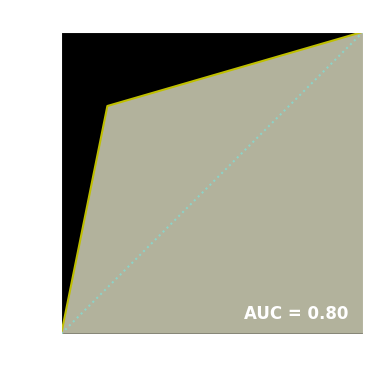

In [15]:
# Get score
print(f'\nScore: {gs.score(features_test, labels_test)}')

# Predict results
labels_preds = gs.predict(features_test)
par_lr = parameter_check(labels_preds, labels_test)

### Correlation matrix

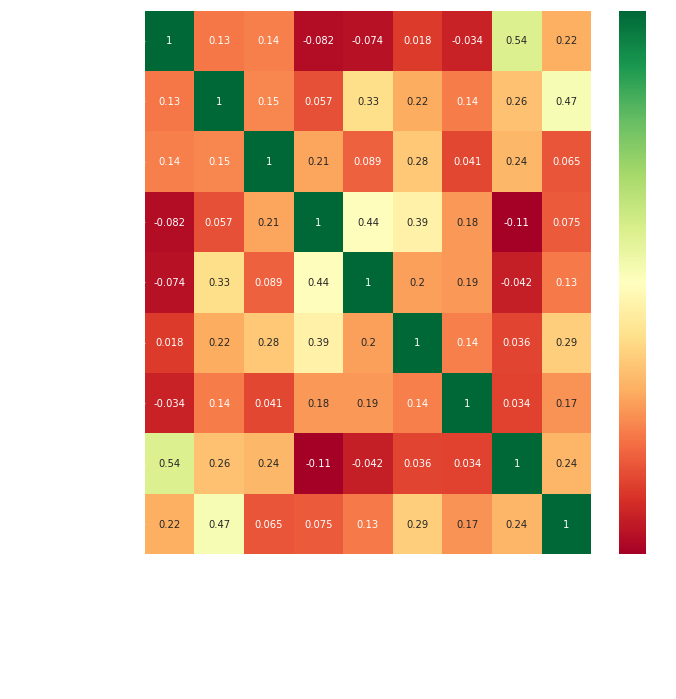

In [16]:
corrmat = dataset.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
g=sns.heatmap(dataset[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Feature Importance Plot

In [17]:
coeff = list(classifier.coef_[0]) # defining coefficient variable
labels = list(features_train.columns) # defining label list
features1 = pd.DataFrame() # Creating a new data frame
features1['Features'] = labels # labels in dataframe
features1['importance'] = coeff # values in dataframe
features1.sort_values(by=['importance'], ascending=True, inplace=True)
features1['positive'] = features1['importance'] > 0 # ranking of feat.
features1.set_index('Features', inplace=True) # Set the DataFrame index

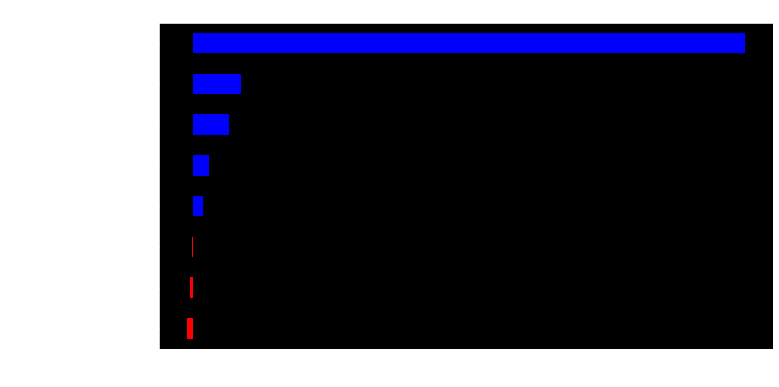

In [18]:
# Creating plot of feature importance
features1.importance.plot(kind='barh', figsize=(11, 6),color =
    features1.positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Importance', color='white')
plt.ylabel('Features', color='white')
plt.title('Feature contribution to diabetes')
plt.show()

In [19]:
data = dataset.copy(deep=True)

In [20]:
# Separating the dependent and independent variables
y = data['BloodPressure']
X = data.drop('BloodPressure', axis = 1)
# Dividing the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [21]:
from sklearn.linear_model import LinearRegression

# Building and fitting the Linear Regression model
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
# Evaluating the Linear Regression model
print(linearModel.score(X_test, y_test))

0.0877581520363575


In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from numpy import mean

# List to maintain the different cross-validation scores
cross_val_scores_ridge = []
# List to maintain the different values of alpha
alpha = []
# Loop to compute the different values of cross-validation scores
for i in range(1, 9):
    ridgeModel = Ridge(alpha = i * 0.25)
    ridgeModel.fit(X_train, y_train)
    scores = cross_val_score(ridgeModel, X, y, cv = 10)
    avg_cross_val_score = mean(scores)*100
    cross_val_scores_ridge.append(avg_cross_val_score)
    alpha.append(i * 0.25)
# Loop to print the different values of cross-validation scores
for i in range(0, len(alpha)):
    print(str(alpha[i])+' : '+str(cross_val_scores_ridge[i]))

0.25 : 12.799465434807658
0.5 : 12.801308047765833
0.75 : 12.80313118490923
1.0 : 12.804935057384787
1.25 : 12.806719873644507
1.5 : 12.808485839486588
1.75 : 12.810233158095677
2.0 : 12.81196203008243


In [23]:
# Building and fitting the Ridge Regression model
ridgeModelChosen = Ridge(alpha = 2)
ridgeModelChosen.fit(X_train, y_train)

# Evaluating the Ridge Regression model
print(ridgeModelChosen.score(X_test, y_test))

0.08807989640308977


In [24]:
from sklearn.linear_model import Lasso

# List to maintain the cross-validation scores
cross_val_scores_lasso = []
# List to maintain the different values of Lambda
Lambda = []
# Loop to compute the cross-validation scores
for i in range(1, 9):
    lassoModel = Lasso(alpha = i * 0.25, tol = 0.0925)
    lassoModel.fit(X_train, y_train)
    scores = cross_val_score(lassoModel, X, y, cv = 10)
    avg_cross_val_score = mean(scores)*100
    cross_val_scores_lasso.append(avg_cross_val_score)
    Lambda.append(i * 0.25)

# Loop to print the different values of cross-validation scores
for i in range(0, len(alpha)):
    print(str(alpha[i])+' : '+str(cross_val_scores_lasso[i]))

0.25 : 12.963582933985526
0.5 : 12.771372905708681
0.75 : 12.671784873091404
1.0 : 12.771167380324652
1.25 : 12.802982119483083
1.5 : 12.867542041678593
1.75 : 12.920381582151736
2.0 : 12.963105120150914


In [25]:
# Building and fitting the Lasso Regression Model
lassoModelChosen = Lasso(alpha = 2, tol = 0.0925)
lassoModelChosen.fit(X_train, y_train)

# Evaluating the Lasso Regression model
print(lassoModelChosen.score(X_test, y_test))

0.09847197371626748


In [26]:
# Building the two lists for visualization
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
scores = [linearModel.score(X_test, y_test),
ridgeModelChosen.score(X_test, y_test),
lassoModelChosen.score(X_test, y_test)]

# Building the dictionary to compare the scores
mapping = {}
mapping['Linear Regreesion'] = linearModel.score(X_test, y_test)
mapping['Ridge Regreesion'] = ridgeModelChosen.score(X_test, y_test)
mapping['Lasso Regression'] = lassoModelChosen.score(X_test, y_test)

# Printing the scores for different models
for key, val in mapping.items():
    print(str(key)+' : '+str(val))

Linear Regreesion : 0.0877581520363575
Ridge Regreesion : 0.08807989640308977
Lasso Regression : 0.09847197371626748


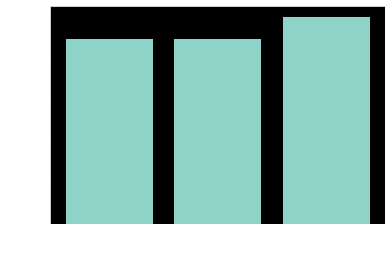

In [27]:
# Plotting the scores
plt.bar(models, scores)
plt.xlabel('Regression Models', color='white')
plt.ylabel('Score', color='white')
plt.show()